# Business Case 
## Population Analysis using SQL

# Import Data

I used the Azure Import Wizard to import the three csv files:

- Z\_CS\_MBR\_ELIG - Member Eligibility
- Z\_CS\_MBR\_ELIG\_MTHS - Member Month 
- Z\_CS\_CLAIM\_HDR - Claims Header

I modified the data types as needed to successfully import filed into tables. Changes include:

- Reformatted the clinical condition columns (Diabetes, Vascular Disease, etc) to tinyint. I recognize that these are binary, bit columns however I encountered errors when loading the data as bit and binary.
    
- Reformatted NPI to NVARCHAR in case of any leading or trailing zeros

In [9]:
import re
a1 = 'samp"le s"tring'
a2 = re.sub('"','',a1)
print(a2) 

sample string


# Cursory Review of Data

- **Z\_CS\_MBR\_ELIG - Member Eligibility**
    
    - 80 records
    - 80 unique Member\_IDs
    - No null values in Payer, LOB, Member\_ID, or DOB columns
    - _Note:_ 26 of the 80 Member\_IDs have an unknown Race/Ethnicity making this column less useful in analysis 
    - Members distributed evenly across Payers/LOBs





In [10]:
sql_query = """
SELECT PAYER, LOB, COUNT(*) AS "# Of Members"  
FROM Z_CS_MBR_ELIG  
GROUP BY PAYER, LOB;
"""

- **Z\_CS\_MBR\_ELIG\_MTH - Member Months**
    
    - 825 records
    - 80 unique Member\_IDs
    - No null values in Payer, LOB, Member\_ID, EFFPER, or Practice columns
    - Between 83 and 88% of members are eligible during any given month


In [11]:
sql_query = """
SELECT EFFPER, COUNT(DISTINCT MEMBER_ID)  
AS "Unique Members"  
FROM Z_CS_MBR_ELIG_MTH  
GROUP BY EFFPER  
ORDER BY EFFPER ASC;
"""

- **Z\_CS\_CLAIM\_HDR - Claim Header**
    
    - 3,230 records
    - 80 unique Member\_IDs
    - No null values in Payer, LOB, Member\_ID, Claim\_ID, or Date of Service columns
    - Approximately 50% of members have claims in a given month



In [12]:
sql_query = """
SELECT MONTH(DATE_OF_SERVICE) AS "Month"
COUNT(DISTINCT MEMBER_ID)
AS '# of Members with Claims'
FROM Z_CS_CLAIM_HDR
GROUP BY MONTH(DATE_OF_SERVICE)
ORDER BY MONTH(DATE_OF_SERVICE) ASC;
"""



# Assumptions for Table Joins

_**Member\_ID is the unique key** which represents a member and is consistent across the three tables.  Tables will be joined on this column._

- **Z\_CS\_MBR\_ELIG - Member Eligibility**
    
    - Each row and Member\_ID represents a unique member with eligibility at any time during 2020
    - One record per Member\_ID (N=80)
    - The Member\_IDs in this file are inclusive of Member\_IDs in the Member Months and Claims Header tables
    - This table will be used as the **_Left Outer Join_** table
- **Z\_CS\_MBR\_ELIG\_MTH - Member Months**
    
    - Member\_ID repeats for every month the member is eligible
    - 80 unique Member\_IDs, 825 total records across 12 months
    - When joining to the Member Eligibility table, this will be the **_Right Inner Join_** table
- **Z\_CS\_CLAIM\_HDR - Claim Header**
    
    - Member\_IDs repeat for each claim. 80 unique members incurred over 3,000 claims in the 12 month period
    - Not all members will have a claim record.  Approximately 50% of members have claims in a given month
    - When joining to the Member Eligibility table, this will be the **_Right Inner Join_** table



# Analysis

## Prompt 1

### What are the top 3 practices with the most patients?

**Code**\
The code below shows the number of unique members assocated with a practice and NPI combination.  

In [13]:
sql_query = """ 
SELECT PRACTICE, COUNT(DISTINCT MEMBER_ID) AS "Unique Members" 
FROM Z_CS_MBR_ELIG_MTH
GROUP BY PRACTICE 
ORDER BY COUNT(DISTINCT MEMBER_ID) DESC;
"""

**Result**\
Members are distributed across 50 practices with the highest number of members pertaining to:

- Mount Sinai Doctors - Nesconset, Long Island (5 Members)
- Mount Sinai Doctors - Staten Island (Victory Internal Medicine) (5 Members)
- Another 5 members are associated with an unknown or unaffiliated practice.  !



## Prompt 2

### What NPI & Practice has the highest volume of Diabetic Patients? (Having Diabetes at any point in time)

**Code** 
The code below filters members with a Diabetes Flag = 1 at any point in time and groups them by practice and NPI


In [32]:
sql_query = """  
SELECT NPI, PRACTICE, COUNT(DISTINCT MEMBER_ID) AS "# Of Members"
FROM Z_CS_MBR_ELIG_MTH
WHERE DIABETES = 1
GROUP BY NPI, PRACTICE
ORDER BY COUNT(DISTINCT MEMBER_ID) DESC;

SELECT COUNT(DISTINCT MEMBER_ID)
FROM Z_CS_MBR_ELIG_MTH
WHERE DIABETES = 1;
"""

**Result**

 - The provider with NPI 1225083546 at Mount Sinai Doctors Staten Island account for the most members with diabetes at any time during 2020.  
 - Of the 80 total members, with diabetes 41 (51%) have diabetes.  The above NPI and practice combination account for 7%.


## Prompt 3

### Calculate the Per Member Per Month Paid Amount of Diabetic Patients vs. Non-Diabetic Patients

**Code**
The code below creates 2 new tables: 
 - (1) Create one row per member with 1,0 for the Diabetes Flag, total member months for the member as well as the Total Cost of Care (TCC).  
 - (2) Calculate the PMPM by dividing the sum of the total cost of care (TCC) column by the # total number of members months for members with Diabetes and without Diabetes. 

_**Note from analyst** - I realize that there is subquery function which would have made this more efficient, but for the sake of time, I used brute force and created new tables.  Note that I did include a drop table function._


In [15]:
sql_query = """
IF OBJECT_ID('dbo.DIABETES', 'U') IS NOT NULL
DROP TABLE dbo.DIABETES

SELECT 
Z_CS_MBR_ELIG_MTH.MEMBER_ID AS 'MEMBER', 
COUNT(DISTINCT Z_CS_MBR_ELIG_MTH.EFFPER) AS 'MBR_MONTHS',
MAX(DIABETES) AS 'DIAB_FLAG'
INTO dbo.DIABETES 
FROM Z_CS_MBR_ELIG_MTH
GROUP BY Z_CS_MBR_ELIG_MTH.MEMBER_ID

SELECT * FROM DIABETES

IF OBJECT_ID('dbo.PMPM', 'U') IS NOT NULL
DROP TABLE dbo.PMPM

SELECT MEMBER, DIAB_FLAG, MBR_MONTHS, SUM(TCC_PAID) AS 'TCC'
INTO dbo.PMPM
FROM DIABETES 
LEFT OUTER JOIN Z_CS_CLAIM_HDR 
ON (DIABETES.MEMBER = Z_CS_CLAIM_HDR.MEMBER_ID)
GROUP BY MEMBER, MBR_MONTHS, DIAB_FLAG;

SELECT * FROM PMPM

SELECT DIAB_FLAG, COUNT(MEMBER) AS "# Of Members", 
SUM(TCC)/SUM(MBR_MONTHS) AS "PMPM"
FROM PMPM
GROUP BY DIAB_FLAG
"""

The data show that the 41 members who have diabetes incur a PMPM 2.5 times greater than those members without diabetes: -- $2,485 -- versus -- $961

## Prompt  4

### Explore the relationship between patient demographics (age, gender, and race/ethnicity) and patient disease with the total cost of care.  

### Is there any type of trend you can identify? 

**Code** 

The code below also creates a new table to show condition flags, # of Member Months, PMPM, as well as demographic information from the member eligibility table at the member level. 

I also added a new column to identify if a member had any condition during 2020. I was interested to see how much of an impact this has on TCC.

**_Notes from Analyst_** 

  -After doing the table modifications in SQL, I ultimately reverted to Python to show correlation of variables with PMPM.  

-This is an ideal use case linear regression  



In [16]:
sql_query = """
IF OBJECT_ID('dbo.CONDITIONS', 'U') IS NOT NULL
DROP TABLE dbo.CONDITIONS

SELECT Z_CS_MBR_ELIG_MTH.MEMBER_ID AS 'MEMBER', 
COUNT(DISTINCT Z_CS_MBR_ELIG_MTH.EFFPER) AS 'MBR_MONTHS',
MAX(DIABETES) AS 'DIAB_FLAG', MAX(VASCULAR_DISEASE) AS 'VASC', 
MAX(PAD) AS 'PAD', MAX(AMI) AS 'AMI', MAX(COPD) AS 'COPD', 
MAX(CHF) AS 'CHF', MAX(STROKE) AS 'STROKE', 
MAX(ASTHMA) AS 'ASTHMA'
INTO dbo.CONDITIONS
FROM Z_CS_MBR_ELIG_MTH
GROUP BY Z_CS_MBR_ELIG_MTH.MEMBER_ID

SELECT * FROM CONDITIONS

IF OBJECT_ID('dbo.MEMBER_COND', 'U') IS NOT NULL
DROP TABLE dbo.MEMBER_CONDIF OBJECT_ID('dbo.CONDITIONS', 'U') IS NOT NULL
DROP TABLE dbo.CONDITIONS

SELECT MEMBER, MBR_MONTHS, DIAB_FLAG, VASC, PAD, 
AMI, COPD, CHF, STROKE, ASTHMA,
SUM(DIAB_FLAG + VASC + PAD + AMI + COPD + CHF + STROKE + ASTHMA) AS 'COND',
SUM(TCC_PAID) AS 'TCC'
INTO dbo.MEMBER_COND
FROM CONDITIONS 
LEFT OUTER JOIN Z_CS_CLAIM_HDR 
ON (CONDITIONS.MEMBER = Z_CS_CLAIM_HDR.MEMBER_ID)
GROUP BY MEMBER, MBR_MONTHS, DIAB_FLAG, VASC, PAD, 
AMI, COPD, CHF, STROKE, ASTHMA;

SELECT * FROM MEMBER_COND

UPDATE MEMBER_COND 
SET COND = 
CASE
WHEN COND > 0 THEN '1'
ELSE '0'
END

SELECT * FROM MEMBER_COND

SELECT COND, COUNT(MEMBER) AS "# Of Members", 
SUM(TCC)/SUM(MBR_MONTHS) AS "PMPM"
FROM MEMBER_COND
GROUP BY COND
"""


**Results** 

The output shows that members with any condition incur a substantially higher PMPM than members without a condition.  

    - The PMPM for members with a condition is 2,433 compared to 396 for members without a condition
    - There are 53 members (35%) with any type of condition during 2020 and these members make up 92% of total cost of care for the population.  
    



In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from IPython.display import display, HTML
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
from datetime import datetime
from datetime import date


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


The code below shows my analysis in Python.  

After loading in the summary table at the member level, I did the following: 

1. Reformatted the DOB field to a date format (it was loaded in as an object type), and calculated Age.  

2. I ran an correlation heat map using Seaborn (sns) visualization tool.  

**_Notes from Analyst:_** 

- I dropped the COND column to avoid colinearity between this and the individual condition columns.  (note - there is likely colinearity between these columns since many of these conditions are co-occurring.)


- When showing the stats on the newly calculated age field, I noticed that the minimum value is -4 years.  This is for Member ID PAYER4_000001.  The DOB in the original csv file is 01-Jan-26.  After reformatting the spreadsheet to show the four digit year, I found that it is entered as 2026.  

In [18]:
df_members = pd.read_csv('/Users/dolant98/Documents/Job Projects/Results.csv')

In [19]:
df_members["DOB"]= pd.to_datetime(df_members["DOB"])

In [20]:
df_members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   MEMBER      80 non-null     object        
 1   MBR_MONTHS  80 non-null     int64         
 2   DIAB_FLAG   80 non-null     int64         
 3   VASC        80 non-null     int64         
 4   PAD         80 non-null     int64         
 5   AMI         80 non-null     int64         
 6   COPD        80 non-null     int64         
 7   CHF         80 non-null     int64         
 8   STROKE      80 non-null     int64         
 9   ASTHMA      80 non-null     int64         
 10  COND        80 non-null     int64         
 11  DOB         80 non-null     datetime64[ns]
 12  RACE-ETH    80 non-null     object        
 13  GENDER      80 non-null     object        
 14  TCC         80 non-null     int64         
dtypes: datetime64[ns](1), int64(11), object(3)
memory usage: 9.5+ KB


In [21]:
def from_dob_to_age(born):
    today = datetime.today().date()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df_members['DOB'] = df_members['DOB'].apply(lambda x: from_dob_to_age(x))

In [22]:
df_members['DOB'].describe()

count    80.000000
mean     60.237500
std      20.639304
min      -4.000000
25%      53.500000
50%      62.000000
75%      75.250000
max      91.000000
Name: DOB, dtype: float64

In [23]:
df_members_no_cond = df_members.drop(columns = ['COND', 'MBR_MONTHS', 'DOB', 'GENDER','RACE-ETH'])
df_members_no_cond

,MEMBER,DIAB_FLAG,VASC,PAD,AMI,COPD,CHF,STROKE,ASTHMA,TCC
0,PAYER1_000001,0,0,0,0,0,0,0,0,100
1,PAYER1_000002,0,0,0,0,0,0,0,0,1700
2,PAYER1_000003,0,0,0,0,0,0,0,0,7000
3,PAYER1_000004,0,0,0,1,0,0,0,0,800
4,PAYER1_000005,0,0,0,0,0,0,0,0,1400
...,...,...,...,...,...,...,...,...,...,...
75,PAYER4_000016,1,1,0,0,0,1,1,0,105800
76,PAYER4_000017,0,0,0,0,0,0,0,0,1000
77,PAYER4_000018,0,0,0,0,0,0,0,0,1300
78,PAYER4_000019,1,1,1,0,1,0,0,0,109600


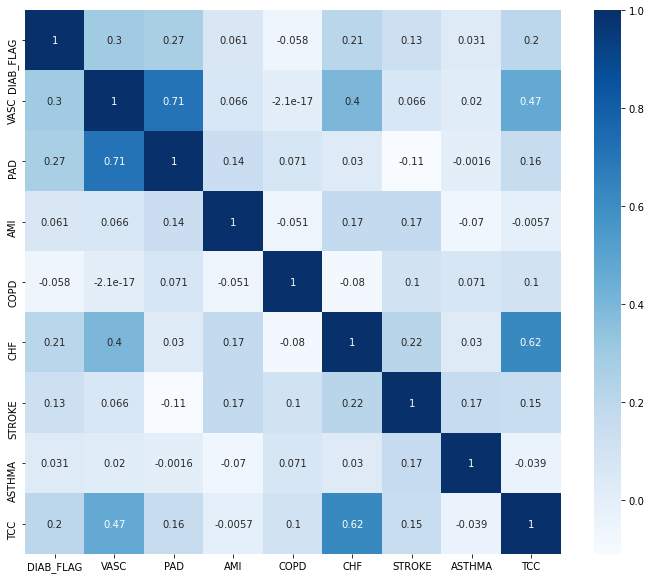

In [24]:
plt.figure(figsize=(12,10))
cor = df_members_no_cond.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

<AxesSubplot:>

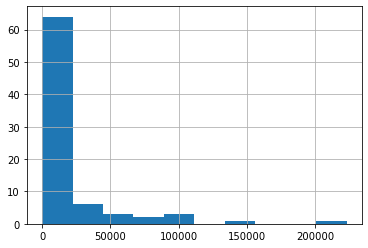

In [25]:
df_members['TCC'].hist()

In [30]:
df_members['PMPM'] = (df_members['TCC']/df_members['MBR_MONTHS'])

In [31]:
df_members

,MEMBER,MBR_MONTHS,DIAB_FLAG,VASC,PAD,AMI,COPD,CHF,STROKE,ASTHMA,COND,DOB,RACE-ETH,GENDER,TCC,PMPM
0,PAYER1_000001,12,0,0,0,0,0,0,0,0,0,46,WHITE,F,100,8.333333
1,PAYER1_000002,12,0,0,0,0,0,0,0,0,0,66,UNKNOWN,M,1700,141.666667
2,PAYER1_000003,12,0,0,0,0,0,0,0,0,0,59,UNKNOWN,M,7000,583.333333
3,PAYER1_000004,12,0,0,0,1,0,0,0,0,1,60,UNKNOWN,M,800,66.666667
4,PAYER1_000005,12,0,0,0,0,0,0,0,0,0,61,UNKNOWN,M,1400,116.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,PAYER4_000016,12,1,1,0,0,0,1,1,0,1,79,WHITE,M,105800,8816.666667
76,PAYER4_000017,12,0,0,0,0,0,0,0,0,0,82,BLACK OR AFRICAN-AMERICAN,F,1000,83.333333
77,PAYER4_000018,12,0,0,0,0,0,0,0,0,0,78,WHITE,F,1300,108.333333
78,PAYER4_000019,12,1,1,1,0,1,0,0,0,1,87,WHITE,M,109600,9133.333333
